In [1]:
import mdtraj as md
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
generated = md.load("/home/dunne/boltz-likelihoods/boltz_results_rfah_ecoli_pred_diff/predictions/rfah_ecoli/rfah_ecoli_model_0.pdb")
print([res.name for res in generated.topology.residues])
print(generated.topology.n_residues)

ideal = md.load("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_pred_diff_large/example_structures/2oug_C.pdb")
print([res.name for res in ideal.topology.residues])
print(ideal.topology.n_residues)

helix = md.load("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_pred_diff_large/example_structures/rfah_ctd_helix.pdb")
print([res.name for res in helix.topology.residues])
print(helix.topology.n_residues)

beta = md.load("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_pred_diff_large/example_structures/rfah_ctd_beta.pdb")
print([res.name for res in beta.topology.residues])
print(beta.topology.n_residues)

['MET', 'GLN', 'SER', 'TRP', 'TYR', 'LEU', 'LEU', 'TYR', 'CYS', 'LYS', 'ARG', 'GLY', 'GLN', 'LEU', 'GLN', 'ARG', 'ALA', 'GLN', 'GLU', 'HIS', 'LEU', 'GLU', 'ARG', 'GLN', 'ALA', 'VAL', 'ASN', 'CYS', 'LEU', 'ALA', 'PRO', 'MET', 'ILE', 'THR', 'LEU', 'GLU', 'LYS', 'ILE', 'VAL', 'ARG', 'GLY', 'LYS', 'ARG', 'THR', 'ALA', 'VAL', 'SER', 'GLU', 'PRO', 'LEU', 'PHE', 'PRO', 'ASN', 'TYR', 'LEU', 'PHE', 'VAL', 'GLU', 'PHE', 'ASP', 'PRO', 'GLU', 'VAL', 'ILE', 'HIS', 'THR', 'THR', 'THR', 'ILE', 'ASN', 'ALA', 'THR', 'ARG', 'GLY', 'VAL', 'SER', 'HIS', 'PHE', 'VAL', 'ARG', 'PHE', 'GLY', 'ALA', 'SER', 'PRO', 'ALA', 'ILE', 'VAL', 'PRO', 'SER', 'ALA', 'VAL', 'ILE', 'HIS', 'GLN', 'LEU', 'SER', 'VAL', 'TYR', 'LYS', 'PRO', 'LYS', 'ASP', 'ILE', 'VAL', 'ASP', 'PRO', 'ALA', 'THR', 'PRO', 'TYR', 'PRO', 'GLY', 'ASP', 'LYS', 'VAL', 'ILE', 'ILE', 'THR', 'GLU', 'GLY', 'ALA', 'PHE', 'GLU', 'GLY', 'PHE', 'GLN', 'ALA', 'ILE', 'PHE', 'THR', 'GLU', 'PRO', 'ASP', 'GLY', 'GLU', 'ALA', 'ARG', 'SER', 'MET', 'LEU', 'LEU', 'LEU'

In [3]:
# find the helix residues in the generated structure
whole_seq = [res.name for res in generated.topology.residues]
helix_seq = [res.name for res in helix.topology.residues]
start_idx = -1
for i in range(generated.topology.n_residues):
    curr_seq = whole_seq[i:i+helix.topology.n_residues]
    if curr_seq == helix_seq:
        print(f"Helix found at residue {i} in generated structure")
        start_idx = i
        break

generated_helix = generated.atom_slice(
    generated.topology.select(f"resid >= {start_idx} and resid <= {start_idx + helix.topology.n_residues - 1}")
    )
print([res.name for res in generated_helix.topology.residues])
print(generated_helix.topology.n_residues)
print([res.name for res in helix.topology.residues])
print(helix.topology.n_residues)

Helix found at residue 114 in generated structure
['LYS', 'VAL', 'ILE', 'ILE', 'THR', 'GLU', 'GLY', 'ALA', 'PHE', 'GLU', 'GLY', 'PHE', 'GLN', 'ALA', 'ILE', 'PHE', 'THR', 'GLU', 'PRO', 'ASP', 'GLY', 'GLU', 'ALA', 'ARG', 'SER', 'MET', 'LEU', 'LEU', 'LEU', 'ASN', 'LEU', 'ILE', 'ASN', 'LYS', 'GLU', 'ILE', 'LYS', 'HIS', 'SER', 'VAL', 'LYS', 'ASN', 'THR', 'GLU', 'PHE', 'ARG', 'LYS', 'LEU']
48
['LYS', 'VAL', 'ILE', 'ILE', 'THR', 'GLU', 'GLY', 'ALA', 'PHE', 'GLU', 'GLY', 'PHE', 'GLN', 'ALA', 'ILE', 'PHE', 'THR', 'GLU', 'PRO', 'ASP', 'GLY', 'GLU', 'ALA', 'ARG', 'SER', 'MET', 'LEU', 'LEU', 'LEU', 'ASN', 'LEU', 'ILE', 'ASN', 'LYS', 'GLU', 'ILE', 'LYS', 'HIS', 'SER', 'VAL', 'LYS', 'ASN', 'THR', 'GLU', 'PHE', 'ARG', 'LYS', 'LEU']
48


In [4]:
helix_rmsds = []
helix_ca = helix.atom_slice(helix.topology.select("name CA"))
beta_rmsds = []
beta_ca = beta.atom_slice(beta.topology.select("name CA"))
path = "/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_subsampled_1/predictions/rfah_ecoli"
for filename in tqdm(os.listdir(path)):
    generated = md.load(f"{path}/{filename}")
    generated = generated.atom_slice(generated.topology.select(
        f"resid >= {start_idx} and resid <= {start_idx + helix.topology.n_residues - 1} and name CA"
        ))
    helix_rmsds.append(md.rmsd(generated, helix_ca)[0])
    beta_rmsds.append(md.rmsd(generated, beta_ca)[0])
helix_rmsds = np.array(helix_rmsds)
beta_rmsds = np.array(beta_rmsds)

 27%|██▋       | 532/2000 [01:14<03:24,  7.17it/s]


KeyboardInterrupt: 

In [21]:
def concat_trajs(path):
    all_trajs = []
    # path = "/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_subsampled_1/predictions/rfah_ecoli"
    for filename in tqdm(os.listdir(path)):
        generated = md.load(f"{path}/{filename}")
        all_trajs.append(generated)
    all_trajs = md.join(all_trajs)
    return all_trajs

sub_1 = concat_trajs("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_subsampled_1/predictions/rfah_ecoli")
sub_10 = concat_trajs("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_subsampled_10/predictions/rfah_ecoli")
sub_100 = concat_trajs("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_subsampled_100/predictions/rfah_ecoli")
sub_1024 = concat_trajs("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_pred_diff_large/predictions/rfah_ecoli")
sub_1_highT= concat_trajs("/data2/scratch/group_scratch/rfah_diffusion/boltz_results_rfah_ecoli_subsampled_1_high_temp/predictions/rfah_ecoli")



100%|██████████| 2000/2000 [00:54<00:00, 36.92it/s]


In [22]:
helix_ca = helix.atom_slice(helix.topology.select("name CA"))
beta_ca = beta.atom_slice(beta.topology.select("name CA"))

sub_1_ctd_ca = sub_1.atom_slice(sub_1.topology.select(
    f"resid >= {start_idx} and resid <= {start_idx + helix.topology.n_residues - 1} and name CA"
    ))
sub_10_ctd_ca = sub_10.atom_slice(sub_10.topology.select(
    f"resid >= {start_idx} and resid <= {start_idx + helix.topology.n_residues - 1} and name CA"
    ))
sub_100_ctd_ca = sub_100.atom_slice(sub_100.topology.select(
    f"resid >= {start_idx} and resid <= {start_idx + helix.topology.n_residues - 1} and name CA"
    ))
sub_1024_ctd_ca = sub_1024.atom_slice(sub_1024.topology.select(
    f"resid >= {start_idx} and resid <= {start_idx + helix.topology.n_residues - 1} and name CA"
    ))
sub_1_highT_ctd_ca = sub_1_highT.atom_slice(sub_1_highT.topology.select(
    f"resid >= {start_idx} and resid <= {start_idx + helix.topology.n_residues - 1} and name CA"
    ))

helix_rmsds_sub_1 = md.rmsd(sub_1_ctd_ca, helix_ca, 0)
helix_rmsds_sub_10 = md.rmsd(sub_10_ctd_ca, helix_ca, 0)
helix_rmsds_sub_100 = md.rmsd(sub_100_ctd_ca, helix_ca, 0)
helix_rmsds_sub_1024 = md.rmsd(sub_1024_ctd_ca, helix_ca, 0)    
helix_rmsds_sub_1_highT = md.rmsd(sub_1_highT_ctd_ca, helix_ca, 0)


beta_rmsds_sub_1 = md.rmsd(sub_1_ctd_ca, beta_ca, 0)
beta_rmsds_sub_10 = md.rmsd(sub_10_ctd_ca, beta_ca, 0)
beta_rmsds_sub_100 = md.rmsd(sub_100_ctd_ca, beta_ca, 0)
beta_rmsds_sub_1024 = md.rmsd(sub_1024_ctd_ca, beta_ca, 0)
beta_rmsds_sub_1_highT = md.rmsd(sub_1_highT_ctd_ca, beta_ca, 0)

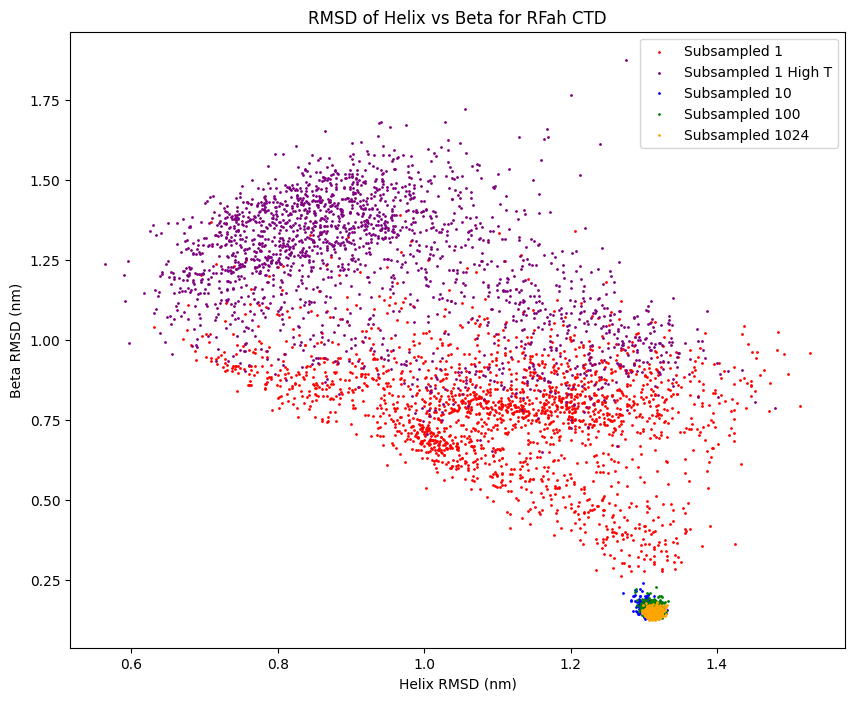

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(helix_rmsds_sub_1, beta_rmsds_sub_1, s=1, label="Subsampled 1", c="red")
ax.scatter(helix_rmsds_sub_1_highT, beta_rmsds_sub_1_highT, s=1, label="Subsampled 1 High T", c="purple")
ax.scatter(helix_rmsds_sub_10, beta_rmsds_sub_10, s=1, label="Subsampled 10", c="blue")
ax.scatter(helix_rmsds_sub_100, beta_rmsds_sub_100, s=1, label="Subsampled 100", c="green")
ax.scatter(helix_rmsds_sub_1024, beta_rmsds_sub_1024, s=1, label="Subsampled 1024", c="orange")
ax.set_xlabel("Helix RMSD (nm)")
ax.set_ylabel("Beta RMSD (nm)")
# ax.set_xlim(0,4)
# ax.set_ylim(0,4)
ax.set_title("RMSD of Helix vs Beta for RFah CTD")
plt.legend()
plt.show()

In [14]:
helix_rmsds_sub_1.argmin()

1782

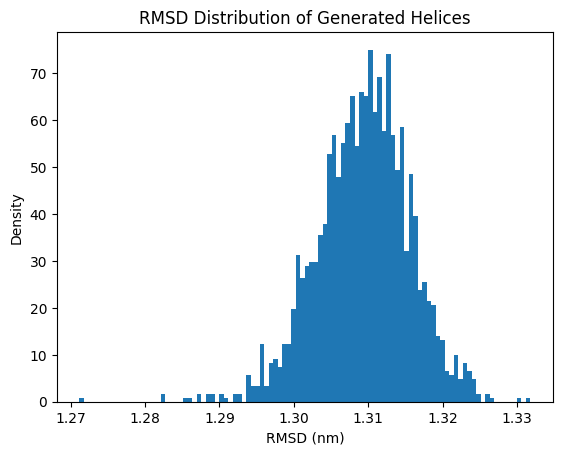

In [ ]:
fig, ax = plt.subplots()
ax.hist(helix_rmsds, bins=100, density=True)
ax.set_xlabel("RMSD (nm)")
ax.set_ylabel("Density")
ax.set_title("RMSD Distribution of Generated Helices")
plt.show()

In [ ]:
np.argmin(all_rmsds)  # Index of the minimum RMSD

NameError: name 'all_rmsds' is not defined